In [1]:
import pickle

import numpy as np

from embeddings.embedding_utils import get_queries, get_query_key

data_queries = get_queries()
embeddings_savepath = "../embedding_results/openai_api__get_embedding"

def get_embedding(category, query):
    query_key = get_query_key(category, query)
    full_filepath = f"{embeddings_savepath}/{query_key}.pkl"
    with open(full_filepath, "rb") as f:
        data_dict = pickle.load(f)
    return data_dict["embeddings"], data_dict["numerical_labels"], data_dict["categorizer"]

In [2]:
category = list(data_queries.keys())[0]
query = data_queries[category][0]

In [3]:
full_embeddings, numerical_labels, categorizer = get_embedding(category, query)
print(f"Load embeddings for {category}: {query}")

Load embeddings for Computer Science and AI: Transformer models


In [4]:
from sklearn.cluster import HDBSCAN

def hdbscan_clustering(embedding, min_cluster_size=5, min_samples=1, max_cluster_size=80):
    hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, max_cluster_size=max_cluster_size)
    labels = hdbscan.fit_predict(embedding)
    return labels


In [10]:
from umap import UMAP

reduced_embedding_2d = UMAP(n_components=2).fit_transform(full_embeddings)

C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


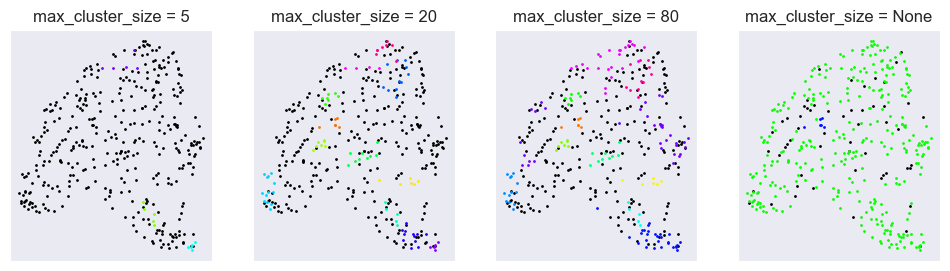

In [11]:
# why max_cluster size should be set
import matplotlib.pyplot as plt
import seaborn as sns
min_cluster_size = 5
min_samples = 1
max_cluster_sizes = [5,20,80, None]

fig, axs = plt.subplots(1,len(max_cluster_sizes),figsize=(3*len(max_cluster_sizes),3))
for i, max_cluster_size in enumerate(max_cluster_sizes):
    ax = axs[i]
    labels = hdbscan_clustering(full_embeddings, min_cluster_size=min_cluster_size, min_samples=min_samples, max_cluster_size=max_cluster_size)
    unique_labels = set(labels)
    non_noise_labels = sorted([label for label in unique_labels if label != -1])

    colors = sns.color_palette("hsv", len(non_noise_labels))
    # Map each non-noise label to a specific color.
    color_dict = {label: colors[i] for i, label in enumerate(non_noise_labels)}

    # Plot noise points (-1) in black.
    mask_noise = labels == -1
    ax.scatter(reduced_embedding_2d[mask_noise, 0],
                     reduced_embedding_2d[mask_noise, 1],
                     color='black', s=1)

    # Plot each non-noise cluster with its assigned color.
    for label in non_noise_labels:
        mask_cluster = labels == label
        ax.scatter(reduced_embedding_2d[mask_cluster, 0],
                         reduced_embedding_2d[mask_cluster, 1],
                         color=color_dict[label],
                         s=1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"max_cluster_size = {max_cluster_size}")
figure_path = "figures_hdbscan_hyperparameters"
plt.savefig(f"{figure_path}/max_cluster_size_variations.png", dpi=300, bbox_inches='tight')
plt.show()



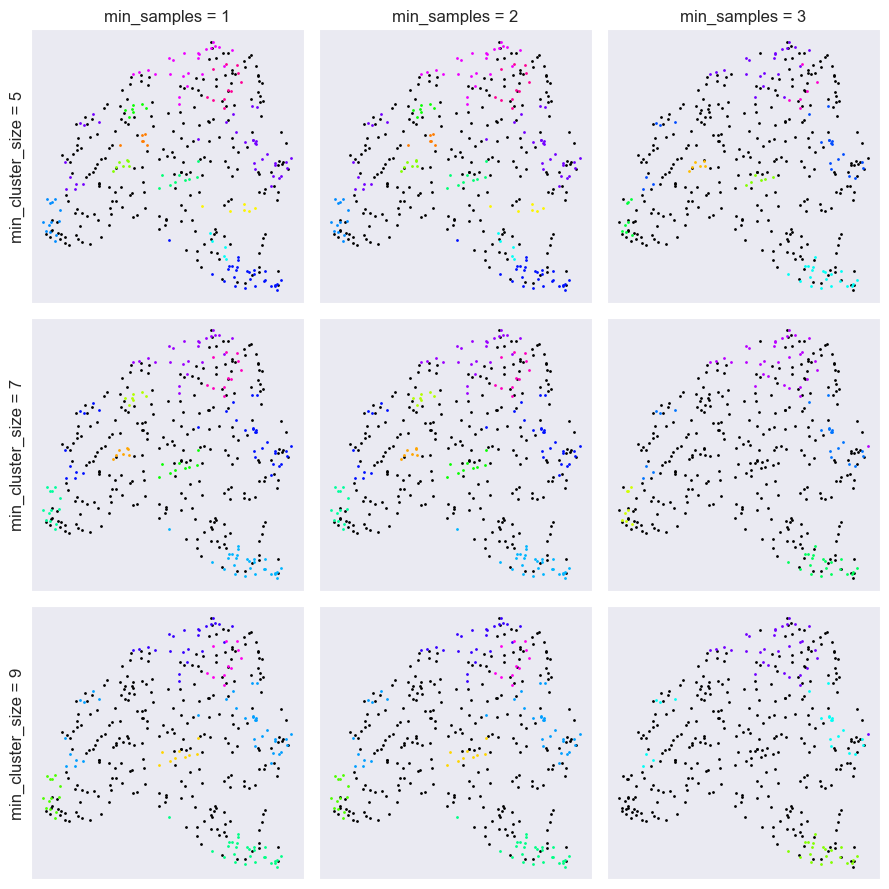

In [12]:

min_cluster_sizes = [5,7,9]
min_samples_ = [1,2,3]

# 3x3 plot with all possible configurations
fig, axs = plt.subplots(len(min_cluster_sizes), len(min_samples_), figsize=(3*len(min_samples_), 3*len(min_cluster_sizes)))
for i in range(len(min_cluster_sizes)):
    for j in range(len(min_samples_)):
        ax=axs[i,j]
        labels = hdbscan_clustering(full_embeddings, min_cluster_size=min_cluster_sizes[i], min_samples=min_samples_[j])

        # Identify unique labels and determine non-noise clusters.
        unique_labels = set(labels)
        non_noise_labels = sorted([label for label in unique_labels if label != -1])

        # Create a color palette using Seaborn's 'hsv' palette.
        colors = sns.color_palette("hsv", len(non_noise_labels))
        # Map each non-noise label to a specific color.
        color_dict = {label: colors[i] for i, label in enumerate(non_noise_labels)}

        # Plot noise points (-1) in black.
        mask_noise = labels == -1
        ax.scatter(reduced_embedding_2d[mask_noise, 0],
                         reduced_embedding_2d[mask_noise, 1],
                         color='black', s=1)

        # Plot each non-noise cluster with its assigned color.
        for label in non_noise_labels:
            mask_cluster = labels == label
            ax.scatter(reduced_embedding_2d[mask_cluster, 0],
                             reduced_embedding_2d[mask_cluster, 1],
                             color=color_dict[label],
                             s=1)

        ax.set_xticks([])
        ax.set_yticks([])
# Annotate the top row with the min_samples values.
for j, ms in enumerate(min_samples_):
    axs[0, j].set_title(f"min_samples = {ms}", fontsize=12)

# Annotate the left column with the min_cluster_size values.
for i, mcs in enumerate(min_cluster_sizes):
    axs[i, 0].set_ylabel(f"min_cluster_size = {mcs}", fontsize=12)
plt.tight_layout()
plt.savefig(f"{figure_path}/min_samples_vs_min_cluster_sizes.png", dpi=300, bbox_inches='tight')
plt.show()

hesitant to form big clusters -> pca and subsquent clustering

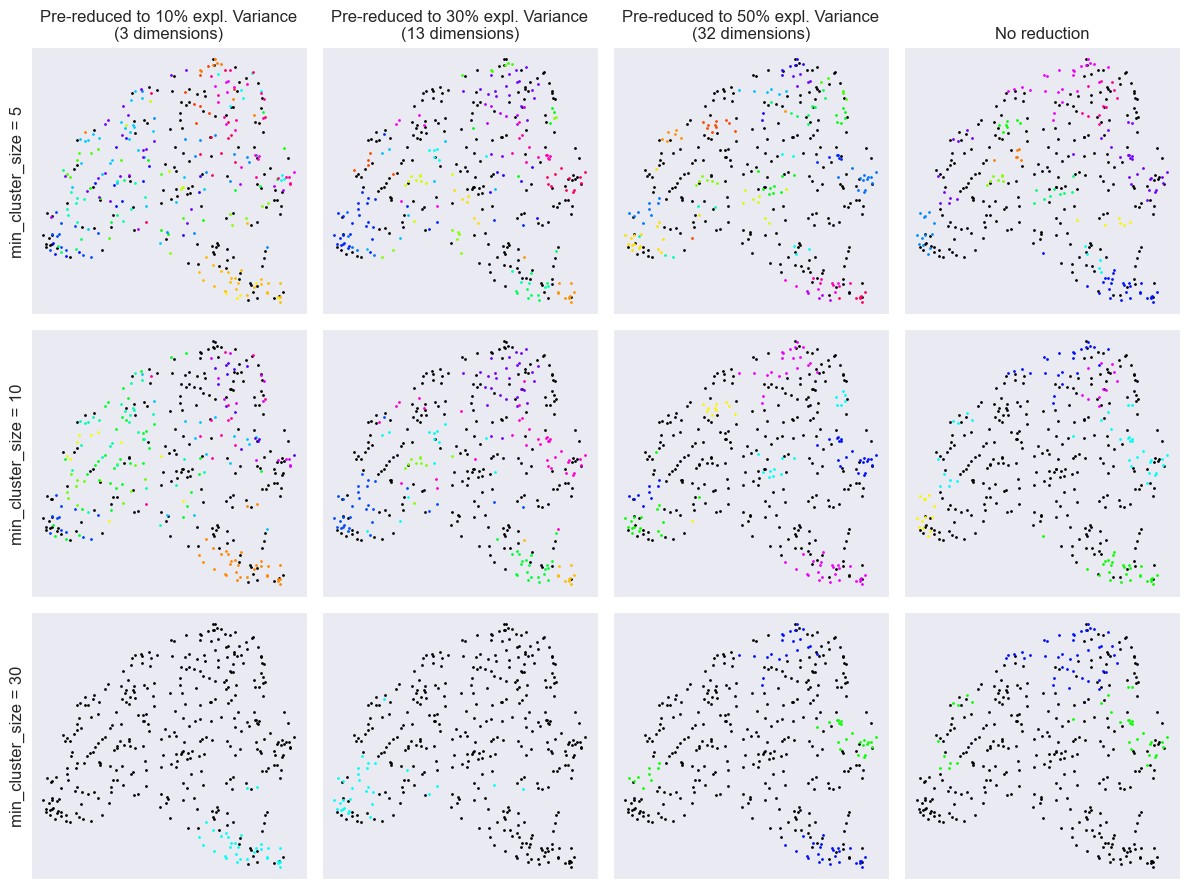

In [24]:
from embeddings.embedding_utils import optimal_pca
reduction_sizes = [0.1,0.3,0.5, None]
reduced_embeddings_nd = [optimal_pca(full_embeddings,reduction_size) if reduction_size is not None else full_embeddings for reduction_size in reduction_sizes]
min_cluster_sizes = [5,10,30]
min_samples = 1

fig, axs = plt.subplots(len(min_cluster_sizes), len(reduction_sizes), figsize=(3*len(reduction_sizes),3*len(min_cluster_sizes)))
for i, min_cluster_size in enumerate(min_cluster_sizes):
    for j, (reduction_size, reduced_embedding) in enumerate(zip(reduction_sizes,reduced_embeddings_nd)):
        ax = axs[i,j]
        labels = hdbscan_clustering(reduced_embedding, min_cluster_size=min_cluster_size, min_samples=min_samples)

        # Identify unique labels and determine non-noise clusters.
        unique_labels = set(labels)
        non_noise_labels = sorted([label for label in unique_labels if label != -1])

        # Create a color palette using Seaborn's 'hsv' palette.
        colors = sns.color_palette("hsv", len(non_noise_labels))
        # Map each non-noise label to a specific color.
        color_dict = {label: colors[i] for i, label in enumerate(non_noise_labels)}

        # Plot noise points (-1) in black.
        mask_noise = labels == -1
        ax.scatter(reduced_embedding_2d[mask_noise, 0],
                         reduced_embedding_2d[mask_noise, 1],
                         color='black', s=1)

        # Plot each non-noise cluster with its assigned color.
        for label in non_noise_labels:
            mask_cluster = labels == label
            ax.scatter(reduced_embedding_2d[mask_cluster, 0],
                             reduced_embedding_2d[mask_cluster, 1],
                             color=color_dict[label],
                             s=1)

        ax.set_xticks([])
        ax.set_yticks([])
# Annotate the top row with the min_samples values.
for j, red_size in enumerate(reduction_sizes):
    if red_size is None:
        axs[0, j].set_title(f"No reduction", fontsize=12)
    else:
        axs[0, j].set_title(f"Pre-reduced to {int(red_size*100)}% expl. Variance\n({reduced_embeddings_nd[j].shape[1]} dimensions)", fontsize=12)

# Annotate the left column with the min_cluster_size values.
for i, mcs in enumerate(min_cluster_sizes):
    axs[i, 0].set_ylabel(f"min_cluster_size = {mcs}", fontsize=12)
plt.tight_layout()
plt.savefig(f"{figure_path}/min_cluster_size_vs_reduction_sizes.png", dpi=300, bbox_inches='tight')
plt.show()


So we choose a medium choice of reduction to 30% explained vaiance and min_cluster_size = 5

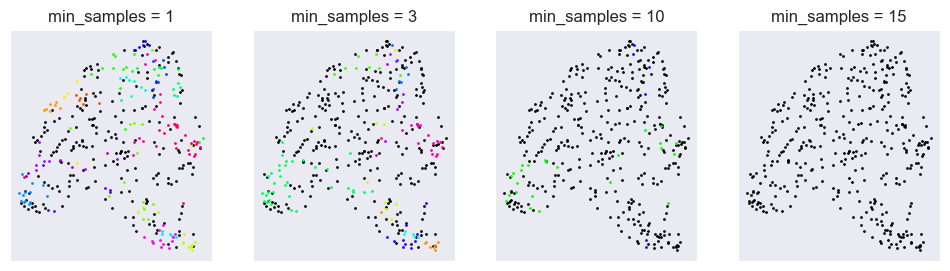

In [28]:
# what min_samples?
min_samples_ = [1,3,10,15]
reduced_embedding_30_expl_var = optimal_pca(full_embeddings,0.4)
min_cluster_size = 5

fig,axs = plt.subplots(1,len(min_samples_), figsize=(3*len(min_samples_), 3))
for i, min_samples in enumerate(min_samples_):
    ax = axs[i]
    labels = hdbscan_clustering(reduced_embedding_30_expl_var, min_cluster_size=min_cluster_size, min_samples=min_samples)
    unique_labels = set(labels)
    non_noise_labels = sorted([label for label in unique_labels if label != -1])

    colors = sns.color_palette("hsv", len(non_noise_labels))
    # Map each non-noise label to a specific color.
    color_dict = {label: colors[i] for i, label in enumerate(non_noise_labels)}

    # Plot noise points (-1) in black.
    mask_noise = labels == -1
    ax.scatter(reduced_embedding_2d[mask_noise, 0],
                     reduced_embedding_2d[mask_noise, 1],
                     color='black', s=1)

    # Plot each non-noise cluster with its assigned color.
    for label in non_noise_labels:
        mask_cluster = labels == label
        ax.scatter(reduced_embedding_2d[mask_cluster, 0],
                         reduced_embedding_2d[mask_cluster, 1],
                         color=color_dict[label],
                         s=1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"min_samples = {min_samples}")
figure_path = "figures_hdbscan_hyperparameters"
plt.savefig(f"{figure_path}/min_samples_variations.png", dpi=300, bbox_inches='tight')
plt.show()

1 looks great, so we settle for min_samples = 1, dim_reduction = 30, min_cluster_size = 5, max_cluster_size = 80

In [26]:
# test against 3 different queries
import numpy as np
n=4
temp_categories = np.random.choice(list(data_queries.keys()), size=n, replace=False)
temp_queries = [np.random.choice(data_queries[temp_categories[i]]) for i in range(n)]

C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\bachelor\article-clustering\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


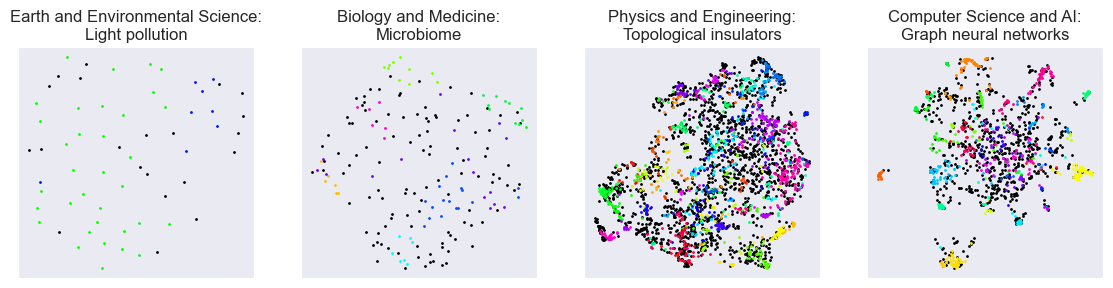

In [29]:

fig, axs = plt.subplots(1, n, figsize=(3.5*n, 3))
for i, (temp_category, temp_query) in enumerate(zip(temp_categories, temp_queries)):
    temp_embeddings,_,_ = get_embedding(temp_category, temp_query)
    temp_reduced_embeddings_30_expl_var = optimal_pca(temp_embeddings,0.4)
    temp_reduced_embeddings_2d = UMAP(n_components=2).fit_transform(temp_embeddings)
    labels = hdbscan_clustering(temp_reduced_embeddings_30_expl_var, min_cluster_size=5, min_samples=1, max_cluster_size=80)

    ax = axs[i]

    unique_labels = set(labels)
    non_noise_labels = sorted([label for label in unique_labels if label != -1])

    colors = sns.color_palette("hsv", len(non_noise_labels))
    # Map each non-noise label to a specific color.
    color_dict = {label: colors[i] for i, label in enumerate(non_noise_labels)}

    # Plot noise points (-1) in black.
    mask_noise = labels == -1
    ax.scatter(temp_reduced_embeddings_2d[mask_noise, 0],
                     temp_reduced_embeddings_2d[mask_noise, 1],
                     color='black', s=1)

    # Plot each non-noise cluster with its assigned color.
    for label in non_noise_labels:
        mask_cluster = labels == label
        ax.scatter(temp_reduced_embeddings_2d[mask_cluster, 0],
                         temp_reduced_embeddings_2d[mask_cluster, 1],
                         color=color_dict[label],
                         s=1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{temp_category}:\n{temp_query}")
figure_path = "figures_hdbscan_hyperparameters"
plt.savefig(f"{figure_path}/final_test_against_other_queries.png", dpi=300, bbox_inches='tight')
plt.show()